In [1]:
from typing import List
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os
import gzip
from tqdm import tqdm
import seaborn as sns
import natsort

In [2]:
def read_files(folder_path):
    all_files = glob.glob(os.path.join(folder_path, "*.csv.gz"))
    all_files = natsort.natsorted(all_files)  # Natural sort files

    fish_data = {}

    for file_path in all_files:
        filename = os.path.basename(file_path)
        fish_id, trial_id = filename.split('_')[0], filename.split('_')[1]

        # Only process the first 3 trials for each fish
        if fish_id not in fish_data:
            fish_data[fish_id] = {}
        if trial_id not in fish_data[fish_id] and len(fish_data[fish_id]) < 3:
            fish_data[fish_id][trial_id] = file_path

    # Debug: Print out the files being processed for each fish
    for fish_id, trials in fish_data.items():
        print(f"Fish ID: {fish_id}, Trials: {list(trials.keys())}")

    return fish_data

In [3]:
def calculate_angles_at_peaks_efficient(df, peaks):

    angles = []
    for i in range(1, len(peaks)):
        # Get the index of the current and previous peak
        prev_peak, current_peak = peaks[i-1], peaks[i]  # Get the index of the current and previous peak

        # Calculate the velocity vectors at the two peaks
        v1 = df.loc[prev_peak, ['dx', 'dy', 'dz']]
        v2 = df.loc[current_peak, ['dx', 'dy', 'dz']]

        # Handle case where either vector is zero (to avoid division by zero)
        if np.linalg.norm(v1) == 0 or np.linalg.norm(v2) == 0:
            angles.append(np.nan)  # Append NaN for undefined angles
            continue

        # Normalize the vectors
        v1_norm = v1 / np.linalg.norm(v1)
        v2_norm = v2 / np.linalg.norm(v2)

        # Calculate the angle between the vectors
        dot_product = np.clip(np.dot(v1_norm, v2_norm), -1.0, 1.0)  # Clipping for numerical stability
        angle = np.arccos(dot_product)  # Angle in radians

        # Convert to degrees
        angle_degrees = np.degrees(angle)

        # Append to the list of angles
        angles.append(angle_degrees)

    return angles

In [4]:
def find_velocity_peaks(df, fHz):
    height_min, height_max = 0.1, 0.5
    distance = round(fHz / 10)
    width = round(fHz / 100)
    prominence = 0.03

    peaks, properties = find_peaks(df['velocity'], height=(height_min, height_max), 
                                   distance=distance, width=width, prominence=prominence)
    
    print(f"Found {len(peaks)} peaks")
    return peaks, properties


In [5]:
def process_file(file_path, fHz):
    df = pd.read_csv(file_path, compression='gzip')#, nrows=2000)
    fHz=100
    # Preprocessing and velocity calculation
    df['dx'] = df['fishx'].diff().fillna(0)
    df['dy'] = df['fishy'].diff().fillna(0)
    df['dz'] = df['fishz'].diff().fillna(0)
    df['velocity'] = np.sqrt(df['dx']**2 + df['dy']**2 + df['dz']**2) / (1/fHz)
    
    # Find peaks
    peaks, properties = find_velocity_peaks(df, fHz)
    
    # Calculate angles at peaks
    peak_angles = calculate_angles_at_peaks_efficient(df, peaks)
    angle_differences = np.diff(peak_angles)
    
    # Calculate turning bias
    turn_bias = np.sign(angle_differences)


    return df, peaks, peak_angles, angle_differences, turn_bias


In [6]:
def aggregate_results(fish_data, fHz):
    aggregated_data = {}

    for fish_id, trials in fish_data.items():
        aggregated_data[fish_id] = {'turn_bias_per_trial': {}}
        for trial_id, file_path in trials.items():
            _, _, _, _, turn_bias = process_file(file_path, fHz)
            left_turns = np.sum(np.array(turn_bias) == -1)
            right_turns = np.sum(np.array(turn_bias) == 1)
            total_turns = len(turn_bias)
            left_turn_prop = left_turns / total_turns if total_turns > 0 else 0
            right_turn_prop = right_turns / total_turns if total_turns > 0 else 0
            aggregated_data[fish_id]['turn_bias_per_trial'][trial_id] = {
                'left_turn_prop': left_turn_prop,
                'right_turn_prop': right_turn_prop
            }

    return aggregated_data

In [7]:
def plot_statistics(aggregated_data, overall_avg_velocity, overall_var_velocity):
    fish_ids = []
    avg_velocities = []
    var_velocities = []

    for fish_id, data in aggregated_data.items():
        fish_ids.append(fish_id)
        avg_velocities.append(data['avg_velocity'])
        var_velocities.append(data['var_velocity'])

    # Plotting individual fish statistics
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    sns.barplot(x=fish_ids, y=avg_velocities)
    plt.title('Average Velocity by Fish')
    plt.xlabel('Fish ID')
    plt.ylabel('Average Velocity (m/s)')

    plt.subplot(1, 2, 2)
    sns.barplot(x=fish_ids, y=var_velocities)
    plt.title('Variance of Velocity by Fish')
    plt.xlabel('Fish ID')
    plt.ylabel('Variance of Velocity (m/s²)')

    plt.tight_layout()
    plt.show()

    # Plotting population level statistics
    plt.figure(figsize=(7, 5))
    plt.bar(['Population'], [overall_avg_velocity], yerr=[np.sqrt(overall_var_velocity)])
    plt.title('Population Level Average Velocity')
    plt.ylabel('Average Velocity (m/s)')
    plt.show()

In [8]:
def plot_turning_bias(aggregated_data):
    fish_ids = []
    avg_left_turn_props = []
    avg_right_turn_props = []

    for fish_id, data in aggregated_data.items():
        fish_ids.append(fish_id)

        left_turn_props = [trial_data['left_turn_prop'] for trial_data in data['turn_bias_per_trial'].values()]
        right_turn_props = [trial_data['right_turn_prop'] for trial_data in data['turn_bias_per_trial'].values()]

        avg_left_turn_props.append(sum(left_turn_props) / len(left_turn_props) if left_turn_props else 0)
        avg_right_turn_props.append(sum(right_turn_props) / len(right_turn_props) if right_turn_props else 0)

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.bar(fish_ids, avg_left_turn_props, label='Average Left Turn Proportion')
    plt.bar(fish_ids, avg_right_turn_props, bottom=avg_left_turn_props, label='Average Right Turn Proportion')
    plt.xlabel('Fish ID')
    plt.ylabel('Turn Proportion')
    plt.title('Average Turn Bias per Fish')
    plt.xticks(range(len(fish_ids)), labels=fish_ids)
    plt.legend()
    plt.show()


In [9]:
def plot_turn_bias_per_trial(aggregated_data):
    for fish_id, data in aggregated_data.items():
        trials = data['turn_bias_per_trial']
        left_turn_props = [trial_data['left_turn_prop'] for trial_data in trials.values()]
        right_turn_props = [trial_data['right_turn_prop'] for trial_data in trials.values()]
        
        # Plotting
        plt.figure(figsize=(10, 5))
        plt.bar(range(len(trials)), left_turn_props, label='Left Turn Proportion')
        plt.bar(range(len(trials)), right_turn_props, bottom=left_turn_props, label='Right Turn Proportion')
        plt.xlabel('Trials')
        plt.ylabel('Turn Proportion')
        plt.title(f'Turn Bias per Trial for Fish {fish_id}')
        plt.xticks(range(len(trials)), labels=trials.keys())
        plt.legend()
        plt.show()


In [10]:
def plot_turn_bias_boxplot(aggregated_data):
    plot_data = {'Fish ID': [], 'Trial': [], 'Left Turn Proportion': [], 'Right Turn Proportion': []}
    for fish_id, data in aggregated_data.items():
        for trial_id, trial_data in data['turn_bias_per_trial'].items():
            plot_data['Fish ID'].append(fish_id)
            plot_data['Trial'].append(trial_id)
            plot_data['Left Turn Proportion'].append(trial_data['left_turn_prop'])
            plot_data['Right Turn Proportion'].append(trial_data['right_turn_prop'])

    df_plot = pd.DataFrame(plot_data)

    # Plotting
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Fish ID', y='Left Turn Proportion', data=df_plot, palette="Set3")
    sns.boxplot(x='Fish ID', y='Right Turn Proportion', data=df_plot, palette="Set1")
    plt.title('Turn Bias Distribution by Fish')
    plt.xlabel('Fish ID')
    plt.ylabel('Turn Proportion')
    plt.show()


In [11]:
def plot_combined(aggregated_data):
    plot_data = []
    for fish_id, data in aggregated_data.items():
        for trial_id, trial_data in data['turn_bias_per_trial'].items():
            plot_data.append({
                'Fish ID': fish_id,
                'Trial': trial_id,
                'Left Turn Proportion': trial_data['left_turn_prop'],
                'Right Turn Proportion': trial_data['right_turn_prop']
            })

    df_plot = pd.DataFrame(plot_data)

    # Plotting Left Turn Proportion
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Fish ID', y='Left Turn Proportion', data=df_plot, palette="Set3")
    sns.swarmplot(x='Fish ID', y='Left Turn Proportion', data=df_plot, color=".25")
    plt.title('Left Turn Proportion by Fish and Trial')
    plt.xlabel('Fish ID')
    plt.ylabel('Left Turn Proportion')
    plt.show()

    # Plotting Right Turn Proportion
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Fish ID', y='Right Turn Proportion', data=df_plot, palette="Set3")
    sns.swarmplot(x='Fish ID', y='Right Turn Proportion', data=df_plot, color=".25")
    plt.title('Right Turn Proportion by Fish and Trial')
    plt.xlabel('Fish ID')
    plt.ylabel('Right Turn Proportion')
    plt.show()


In [12]:

def plot_velocity_with_detected_peaks(df, peaks):
    plt.figure(figsize=(30, 10))
    plt.plot(df['velocity'], label='Velocity')
    plt.plot(peaks, df['velocity'][peaks], "x", label='Peaks')
    plt.title("Velocity with Detected Peaks")
    plt.xlabel("Frame")
    plt.ylabel("Velocity")
    plt.legend()
    plt.show()

In [13]:
# Assuming process_file returns the required elements correctly
fHz = 100  # Frames per second
folder_path = "/home/kkumari/PhD/fish-data/long-term-free-swim/"
fish_data = read_files(folder_path)
# Select an example file (assuming fish_data contains paths)
example_file = next(iter(fish_data[next(iter(fish_data))].values()))
df_example, peaks, _, _, _ = process_file(example_file, fHz)
# plot_velocity_with_detected_peaks(df_example, peaks)


Fish ID: 01, Trials: ['T1', 'T2', 'T3']
Fish ID: 02, Trials: ['T1', 'T2', 'T3']
Fish ID: 03, Trials: ['T1', 'T2', 'T4']
Fish ID: 04, Trials: ['T1', 'T2', 'T3']
Fish ID: 05, Trials: ['T1', 'T2', 'T3']
Fish ID: 06, Trials: ['T1', 'T2', 'T3']
Fish ID: 07, Trials: ['T1', 'T2', 'T3']
Fish ID: 08, Trials: ['T1', 'T2', 'T3']
Fish ID: 09, Trials: ['T1', 'T2', 'T3']
Fish ID: 10, Trials: ['T1', 'T2', 'T3']
Fish ID: 11, Trials: ['T1', 'T2', 'T3']
Fish ID: 12, Trials: ['T1', 'T2', 'T3']
Fish ID: 13, Trials: ['T1', 'T2', 'T3']
Fish ID: 14, Trials: ['T1', 'T2', 'T3']
Fish ID: 15, Trials: ['T1', 'T2', 'T3']
Fish ID: 16, Trials: ['T1', 'T2', 'T3']
Found 22966 peaks


Found 22966 peaks
Found 17358 peaks
Found 23886 peaks
Found 21639 peaks
Found 23738 peaks
Found 24074 peaks
Found 19773 peaks
Found 21808 peaks
Found 27215 peaks
Found 20925 peaks
Found 20577 peaks
Found 20187 peaks
Found 17423 peaks
Found 21658 peaks
Found 24274 peaks
Found 17624 peaks
Found 19371 peaks
Found 19867 peaks
Found 21569 peaks
Found 24094 peaks
Found 25790 peaks
Found 22120 peaks
Found 23355 peaks
Found 22936 peaks
Found 13420 peaks
Found 14839 peaks
Found 19090 peaks
Found 17254 peaks
Found 18685 peaks
Found 18674 peaks
Found 20027 peaks
Found 24818 peaks
Found 25754 peaks
Found 22220 peaks
Found 15055 peaks
Found 15797 peaks
Found 19353 peaks
Found 21690 peaks
Found 23216 peaks
Found 19291 peaks
Found 23944 peaks
Found 21566 peaks
Found 21567 peaks
Found 25583 peaks
Found 26459 peaks
Found 15618 peaks
Found 21236 peaks
Found 21459 peaks


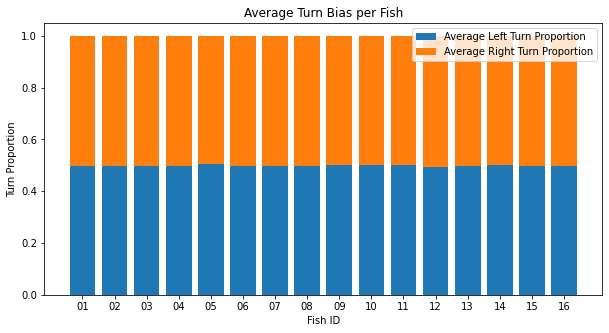

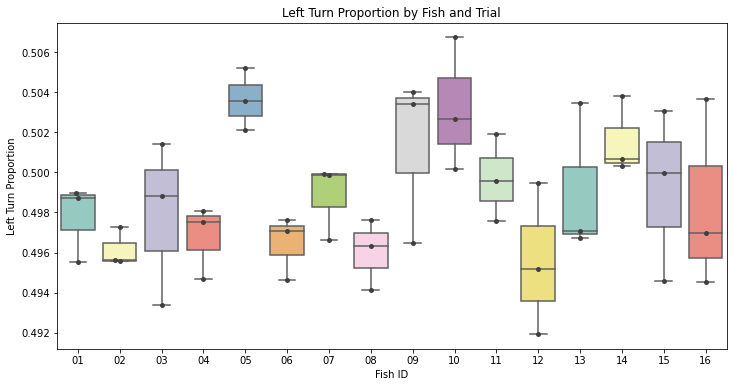

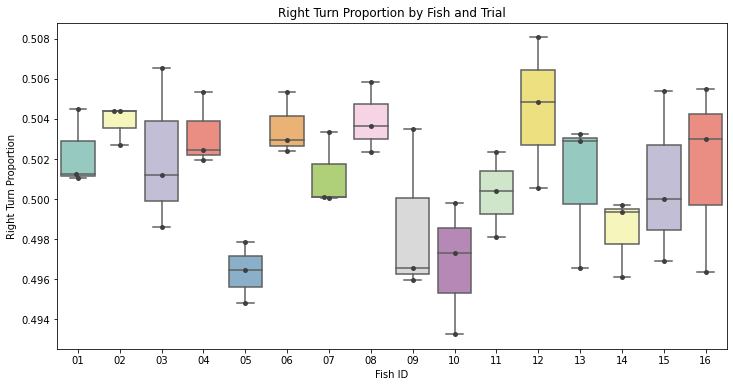

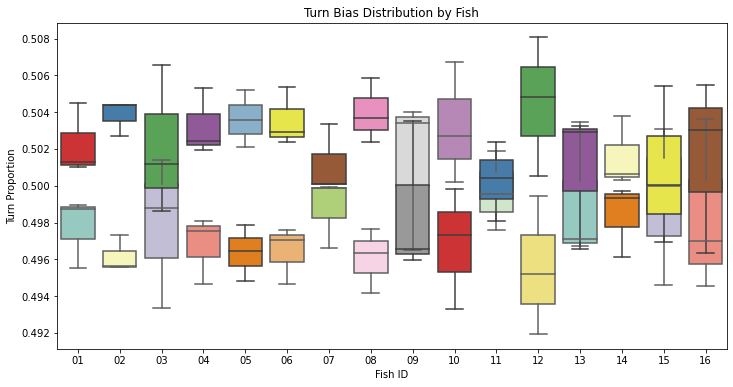

In [14]:

fHz = 100  # or the appropriate value for your data
aggregated_data = aggregate_results(fish_data, fHz)
plot_turning_bias(aggregated_data)
plot_combined(aggregated_data)
# plot_turn_bias_per_trial(aggregated_data)
plot_turn_bias_boxplot(aggregated_data)

In [15]:
def save_turn_bias_values(aggregated_data, file_path):
    data_to_save = []
    for fish_id, data in aggregated_data.items():
        for trial_id, trial_data in data['turn_bias_per_trial'].items():
            data_to_save.append({
                'Fish ID': fish_id,
                'Trial': trial_id,
                'Left Turn Proportion': trial_data['left_turn_prop'],
                'Right Turn Proportion': trial_data['right_turn_prop']
            })

    df_to_save = pd.DataFrame(data_to_save)
    df_to_save.to_csv(file_path, index=False)

# Example usage
save_turn_bias_values(aggregated_data, '/home/kkumari/PhD/data-analysis/individual-behavior/long-term-free-turn_bias_values.csv')


In [16]:
def plot_average_velocity_boxplot(avg_velocity_data):
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Fish ID', y='Average Velocity', data=avg_velocity_data, palette="Set3")
    plt.title('Average Velocity per Trial by Fish')
    plt.xlabel('Fish ID')
    plt.ylabel('Average Velocity')
    plt.show()

In [17]:
def save_average_velocity(fish_data, fHz, output_file_path):
    avg_velocity_data = []
    for fish_id, trials in fish_data.items():
        for trial_id, file_path in trials.items():
            df, _, _, _, _ = process_file(file_path, fHz)
            avg_velocity = df['velocity'].mean()
            avg_velocity_data.append({
                'Fish ID': fish_id,
                'Trial': trial_id,
                'Average Velocity': avg_velocity
            })

    df_avg_velocity = pd.DataFrame(avg_velocity_data)
    df_avg_velocity.to_csv(output_file_path, index=False)
    return df_avg_velocity

# Example usage
fHz = 100  # Frames per secon

# # Example usage
# save_average_velocity(fish_data, fHz, output_file_path='/home/kkumari/PhD/data-analysis/individual-behavior/long-term-free-average_velocity.csv')
# plot_average_velocity_boxplot(avg_velocity_data)

In [18]:
fHz = 100  # Frames per second
output_file_path = '/home/kkumari/PhD/data-analysis/individual-behavior/long-term-free-average_velocity.csv'  # Adjust the path as needed
avg_velocity_data = save_average_velocity(fish_data, fHz, output_file_path)

Found 22966 peaks
Found 17358 peaks
Found 23886 peaks
Found 21639 peaks
Found 23738 peaks
Found 24074 peaks
Found 19773 peaks
Found 21808 peaks
Found 27215 peaks
Found 20925 peaks
Found 20577 peaks
Found 20187 peaks
Found 17423 peaks
Found 21658 peaks
Found 24274 peaks
Found 17624 peaks
Found 19371 peaks
Found 19867 peaks
Found 21569 peaks
Found 24094 peaks
Found 25790 peaks
Found 22120 peaks
Found 23355 peaks
Found 22936 peaks
Found 13420 peaks
Found 14839 peaks
Found 19090 peaks
Found 17254 peaks
Found 18685 peaks
Found 18674 peaks
Found 20027 peaks
Found 24818 peaks
Found 25754 peaks
Found 22220 peaks
Found 15055 peaks
Found 15797 peaks
Found 19353 peaks
Found 21690 peaks
Found 23216 peaks
Found 19291 peaks
Found 23944 peaks
Found 21566 peaks
Found 21567 peaks
Found 25583 peaks
Found 26459 peaks
Found 15618 peaks
Found 21236 peaks
Found 21459 peaks


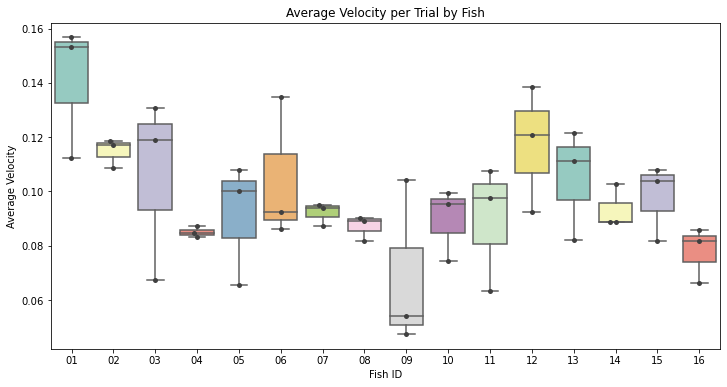

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_average_velocity_boxplot(avg_velocity_data):
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Fish ID', y='Average Velocity', data=avg_velocity_data, palette="Set3")
    sns.swarmplot(x='Fish ID', y='Average Velocity', data=avg_velocity_data, color=".25")
    plt.title('Average Velocity per Trial by Fish')
    plt.xlabel('Fish ID')
    plt.ylabel('Average Velocity')
    plt.show()

# Assuming avg_velocity_data is the DataFrame created in save_average_velocity
plot_average_velocity_boxplot(avg_velocity_data)

In [20]:
# Create a list to hold the data
data_to_save = []

# Extract data from aggregated_data
for fish_id, data in aggregated_data.items():
    for metric, value in data.items():
        if isinstance(value, list):  # If the metric contains a list of values
            for v in value:
                data_to_save.append({'Fish ID': fish_id, 'Metric': metric, 'Value': v})
        else:  # If the metric is a single value
            data_to_save.append({'Fish ID': fish_id, 'Metric': metric, 'Value': value})

# Create a DataFrame
df_to_save = pd.DataFrame(data_to_save)

In [21]:
# Define the file path for the CSV file
output_file_path = '/home/kkumari/PhD/data-analysis/individual-behavior/long-term-sd.csv'

# Save the DataFrame to a CSV file
df_to_save.to_csv(output_file_path, index=False)
